### Creating dataset 

In [19]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

class NurseSchedulingDataGenerator:
    def __init__(self, num_nurses=1000, num_days=90, shifts_per_day=3, 
                 num_departments=10, num_certifications=8, num_vaccines=5, 
                 experience_levels=5):
        self.num_nurses = num_nurses
        self.num_days = num_days
        self.shifts_per_day = shifts_per_day
        self.num_departments = num_departments
        self.num_certifications = num_certifications
        self.num_vaccines = num_vaccines
        self.experience_levels = experience_levels
        self.total_shifts = num_days * shifts_per_day

    def generate_nurse_data(self):
        nurses = pd.DataFrame({
            'NurseID': range(1, self.num_nurses + 1),
            'YearsExperience': np.random.randint(0, 20, self.num_nurses),
            'HourlyRate': np.random.uniform(20, 50, self.num_nurses).round(2)
        })
        
        # Generate department qualifications
        for i in range(self.num_departments):
            nurses[f'Dept_{i+1}'] = np.random.choice([0, 1], self.num_nurses, p=[0.3, 0.7])
        
        # Generate certifications
        for i in range(self.num_certifications):
            nurses[f'Cert_{i+1}'] = np.random.choice([0, 1], self.num_nurses, p=[0.5, 0.5])
        
        # Generate vaccines
        for i in range(self.num_vaccines):
            nurses[f'Vaccine_{i+1}'] = np.random.choice([0, 1], self.num_nurses, p=[0.1, 0.9])
        
        # Generate experience levels for each department
        for i in range(self.num_departments):
            nurses[f'Exp_Dept_{i+1}'] = np.random.randint(0, self.experience_levels, self.num_nurses)

        return nurses

    def generate_shift_data(self):
        start_date = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
        shifts = []

        for day in range(self.num_days):
            for shift in range(self.shifts_per_day):
                shift_start = start_date + timedelta(days=day, hours=8*shift)
                shift_end = shift_start + timedelta(hours=8)
                shifts.append({
                    'ShiftID': day * self.shifts_per_day + shift + 1,
                    'Date': shift_start.date(),
                    'StartTime': shift_start.time(),
                    'EndTime': shift_end.time()
                })

        shifts_df = pd.DataFrame(shifts)

        # Generate department requirements
        for i in range(self.num_departments):
            shifts_df[f'Req_Dept_{i+1}'] = np.random.randint(1, 5, len(shifts_df))
        
        # Generate certification requirements
        for i in range(self.num_certifications):
            shifts_df[f'Req_Cert_{i+1}'] = np.random.choice([0, 1], len(shifts_df), p=[0.7, 0.3])
        
        # Generate vaccine requirements
        for i in range(self.num_vaccines):
            shifts_df[f'Req_Vaccine_{i+1}'] = np.random.choice([0, 1], len(shifts_df), p=[0.8, 0.2])
        
        # Generate experience level requirements
        for i in range(self.num_departments):
            shifts_df[f'Req_Exp_Dept_{i+1}'] = np.random.randint(0, self.experience_levels, len(shifts_df))

        return shifts_df

    def generate_nurse_availability(self):
        availability = pd.DataFrame({
            'NurseID': np.repeat(range(1, self.num_nurses + 1), self.total_shifts),
            'ShiftID': np.tile(range(1, self.total_shifts + 1), self.num_nurses),
            'IsAvailable': np.random.choice([0, 1], self.num_nurses * self.total_shifts, p=[0.3, 0.7])
        })
        return availability

    def generate_fraud_risk_factors(self):
        fraud_risk = pd.DataFrame({
            'NurseID': range(1, self.num_nurses + 1),
            'PastIncidents': np.random.randint(0, 3, self.num_nurses),
            'LatePunchIns': np.random.randint(0, 10, self.num_nurses),
            'UnexplainedAbsences': np.random.randint(0, 5, self.num_nurses)
        })
        return fraud_risk

    def generate_all_data(self):
        nurses = self.generate_nurse_data()
        shifts = self.generate_shift_data()
        availability = self.generate_nurse_availability()
        fraud_risk = self.generate_fraud_risk_factors()
        
        return {
            'nurses': nurses,
            'shifts': shifts,
            'availability': availability,
            'fraud_risk': fraud_risk
        }

# Usage
generator = NurseSchedulingDataGenerator()
data = generator.generate_all_data()

# Print sample data
print("Sample Nurse Data:")
print(data['nurses'].head())
print("\nSample Shift Data:")
print(data['shifts'].head())
print("\nSample Availability Data:")
print(data['availability'].head())
print("\nSample Fraud Risk Data:")
print(data['fraud_risk'].head())

# Print total number of shifts
print(f"\nTotal number of shifts: {len(data['shifts'])}")

# Save to CSV files
data['nurses'].to_csv('nurses.csv', index=False)
data['shifts'].to_csv('shifts.csv', index=False)
data['availability'].to_csv('availability.csv', index=False)
data['fraud_risk'].to_csv('fraud_risk.csv', index=False)

Sample Nurse Data:
   NurseID  YearsExperience  HourlyRate  Dept_1  Dept_2  Dept_3  Dept_4  \
0        1                4       40.06       0       1       1       1   
1        2               16       31.42       1       1       0       0   
2        3                6       45.41       1       1       1       1   
3        4                4       43.92       1       1       0       1   
4        5                1       33.74       0       1       1       0   

   Dept_5  Dept_6  Dept_7  ...  Exp_Dept_1  Exp_Dept_2  Exp_Dept_3  \
0       0       1       1  ...           0           0           1   
1       1       1       0  ...           3           3           4   
2       0       1       1  ...           4           3           2   
3       1       0       1  ...           1           4           0   
4       0       1       1  ...           0           0           0   

   Exp_Dept_4  Exp_Dept_5  Exp_Dept_6  Exp_Dept_7  Exp_Dept_8  Exp_Dept_9  \
0           2           3       

### Optimization Problem

In [20]:
import numpy as np
import pandas as pd
from scipy.optimize import linprog
import matplotlib.pyplot as plt

# Define sets and parameters
nurses = 1000  # Adjust based on your dataset
shifts = 90  # 30 days * 3 shifts per day
departments = 10
certifications = 8
vaccines = 5
experience_levels = 5

# Uncertainty parameters
uncertainty_level = 0.1  # 10% uncertainty in probabilities

# Fairness parameters
max_assignment_difference = 1  # Maximum difference in number of assignments between nurses

# Fraud detection parameters
fraud_risk_threshold = 0.3  # Threshold for high fraud risk
fraud_detection_weight = 0.2  # Weight of fraud risk in the objective function

def load_nurse_data(file_path='nurses.csv'):
    df = pd.read_csv(file_path)
    D = df[[f'Dept_{i+1}' for i in range(departments)]].values
    C = df[[f'Cert_{i+1}' for i in range(certifications)]].values
    V = df[[f'Vaccine_{i+1}' for i in range(vaccines)]].values
    Y = df[[f'Exp_Dept_{i+1}' for i in range(departments)]].values
    return D, C, V, Y

def load_shift_data(file_path='shifts.csv'):
    df = pd.read_csv(file_path)
    N = df[[f'Req_Dept_{i+1}' for i in range(departments)]].values
    B = df[[f'Req_Cert_{i+1}' for i in range(certifications)]].values
    M = df[[f'Req_Vaccine_{i+1}' for i in range(vaccines)]].values
    F = df[[f'Req_Exp_Dept_{i+1}' for i in range(departments)]].values
    return N, B, M, F

def load_availability_data(file_path='availability.csv'):
    df = pd.read_csv(file_path)
    availability = df.pivot(index='NurseID', columns='ShiftID', values='IsAvailable').fillna(0).values
    return availability

def load_fraud_risk_data(file_path='fraud_risk.csv'):
    df = pd.read_csv(file_path)
    return df[['PastIncidents', 'LatePunchIns', 'UnexplainedAbsences']].values

def calculate_fraud_probabilities(fraud_risk_data):
    # Simplified fraud probability calculation
    fraud_prob = np.mean(fraud_risk_data / np.max(fraud_risk_data, axis=0), axis=1)
    return fraud_prob

def run_model(D, C, V, Y, N, B, M, F, availability, fraud_prob, uncertainty_multiplier=1.0):
    a = availability
    min_prob = 0.01
    a = np.maximum(a, min_prob)

    # Apply uncertainty to acceptance probabilities
    a_lower = a * (1 - uncertainty_level * uncertainty_multiplier)
    a_upper = a * (1 + uncertainty_level * uncertainty_multiplier)

    # Robust optimization: use the lower bound for optimization
    c = np.concatenate([-a_lower.flatten(), [fraud_detection_weight] * nurses])

    num_vars = nurses * shifts + nurses

    # Constraints
    A_eq = np.zeros((shifts, num_vars))
    for j in range(shifts):
        A_eq[j, j*nurses:(j+1)*nurses] = 1
    b_eq = np.ones(shifts)

    # Fairness constraints
    A_fairness = np.zeros((nurses - 1, num_vars))
    for i in range(nurses - 1):
        A_fairness[i, i::nurses] = 1
        A_fairness[i, i+1::nurses] = -1

    # Fraud risk constraints
    A_fraud = np.zeros((nurses, num_vars))
    for i in range(nurses):
        A_fraud[i, i::nurses] = 1
        A_fraud[i, -nurses+i] = -1

    A_ub = np.vstack([A_fairness, -A_fairness, A_fraud])
    b_ub = np.concatenate([np.ones(nurses - 1) * max_assignment_difference, 
                           np.ones(nurses - 1) * max_assignment_difference,
                           np.zeros(nurses)])

    bounds = [(0, 1)] * (nurses * shifts) + [(0, None)] * nurses

    result = linprog(c, A_eq=A_eq, b_eq=b_eq, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method='highs')

    # Calculate the objective value
    assignments = result.x[:nurses*shifts].reshape(nurses, shifts)
    fraud_impact = np.sum(result.x[-nurses:])
    objective_value = -np.sum(a_lower * assignments) - fraud_detection_weight * fraud_impact

    return objective_value, assignments

# Load data
D, C, V, Y = load_nurse_data()
N, B, M, F = load_shift_data()
availability = load_availability_data()
fraud_risk_data = load_fraud_risk_data()
fraud_prob = calculate_fraud_probabilities(fraud_risk_data)

# Run the model
final_result, final_assignments = run_model(D, C, V, Y, N, B, M, F, availability, fraud_prob)

print(f"Objective value (including fraud risk): {final_result}")

# Visualize results
plt.figure(figsize=(12, 6))
plt.imshow(final_assignments, cmap='Blues', aspect='auto')
plt.colorbar(label='Assignment Probability')
plt.xlabel('Shifts')
plt.ylabel('Nurses')
plt.title('Nurse-Shift Assignment Heatmap')
plt.show()

# Fraud risk visualization
plt.figure(figsize=(10, 6))
plt.bar(range(1, nurses + 1), fraud_prob)
plt.axhline(y=fraud_risk_threshold, color='r', linestyle='--')
plt.xlabel('Nurse')
plt.ylabel('Fraud Risk Probability')
plt.title('Fraud Risk Assessment for Nurses')
plt.show()

ValueError: Invalid input for linprog: A_ub must have exactly two dimensions, and the number of columns in A_ub must be equal to the size of c

### Heuristic 

Loading data...
Running fair shift distribution...


Distributing Shifts: 100%|████████████████████| 270/270 [00:22<00:00, 11.84it/s]


Objective value (shown): 2138.8592592592595
Objective value (accepted): 1242.0537037037036
Total shifts shown: 2323
Total shifts accepted: 1350
Total compensation: $407442.49

Match rate: 58.11%


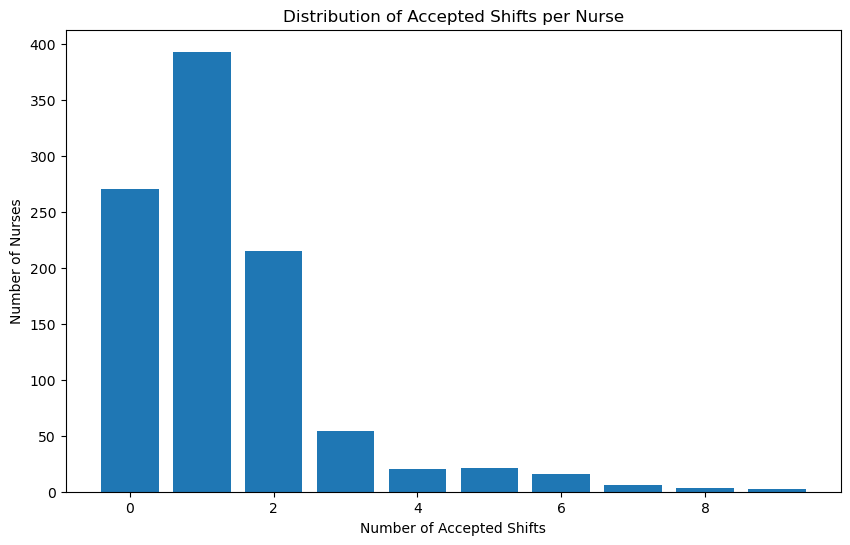

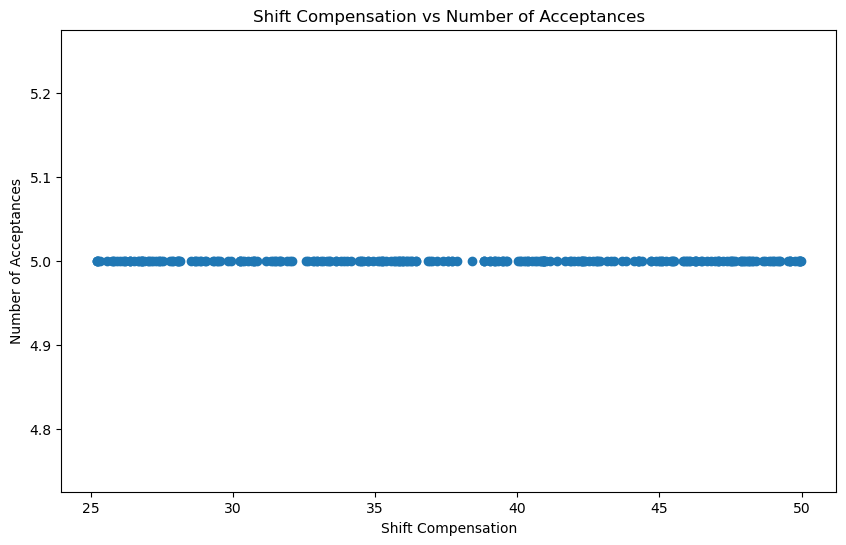

/Users/khaled/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/khaled/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



Correlation between compensation and shift acceptance: nan


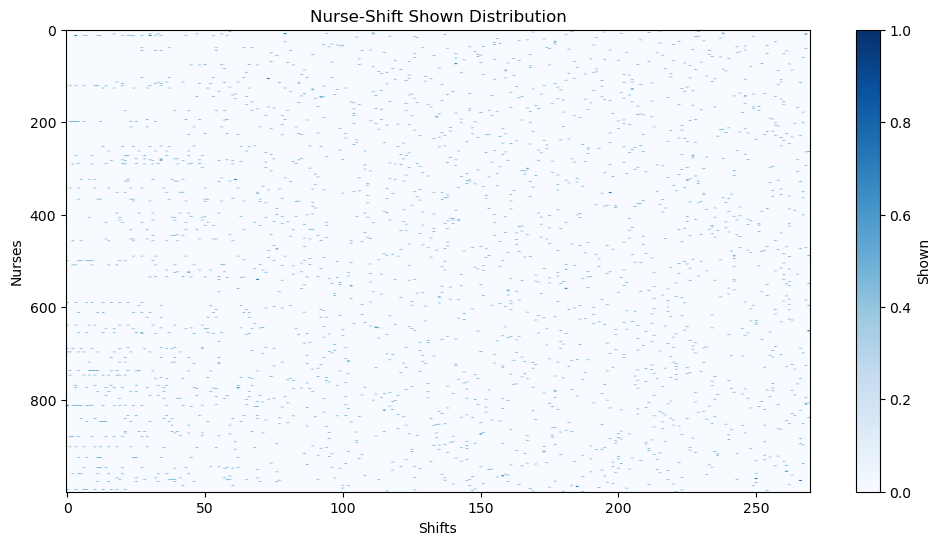

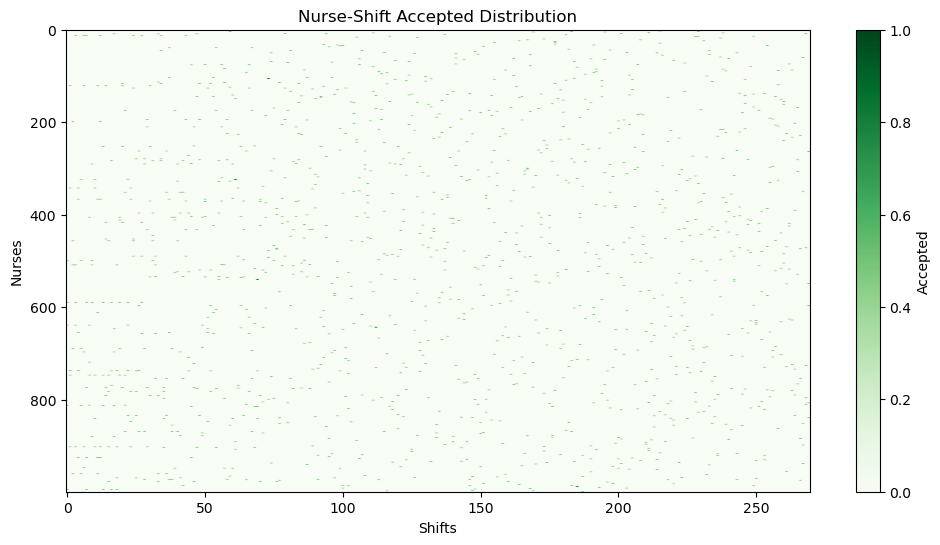

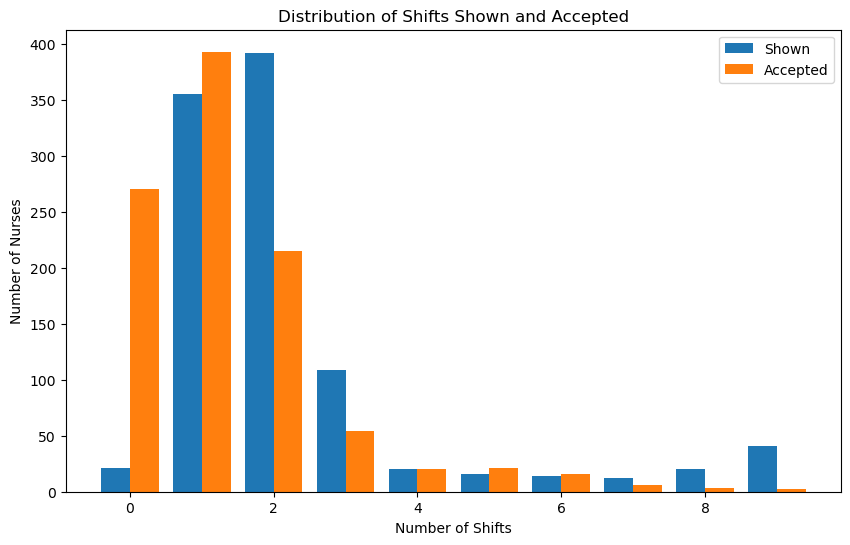


Average shifts shown per nurse: 2.32
Average shifts accepted per nurse: 1.35
Maximum shifts shown to a nurse: 9
Maximum shifts accepted by a nurse: 9
Nurses with no shifts shown: 21
Nurses with no shifts accepted: 270
Nurses shown maximum shifts: 41

Shifts shown to high-risk nurses: 1366
Shifts accepted by high-risk nurses: 815
Percentage of high-risk shown shifts: 58.80%
Percentage of high-risk accepted shifts: 60.37%
Number of low-risk nurses: 165
Shifts shown to low-risk nurses: 957
Shifts accepted by low-risk nurses: 535
Percentage of shifts shown to low-risk nurses: 41.20%
Percentage of shifts accepted by low-risk nurses: 39.63%

Fully shown shifts: 270
Fully accepted shifts: 270
Partially shown shifts: 0
Partially accepted shifts: 0
Not shown shifts: 0
Not accepted shifts: 0
Percentage of fully shown shifts: 100.00%
Percentage of fully accepted shifts: 100.00%

Total positions: 1350
Shown positions: 2323
Accepted positions: 1350
Percentage of shown positions: 172.07%
Percentage

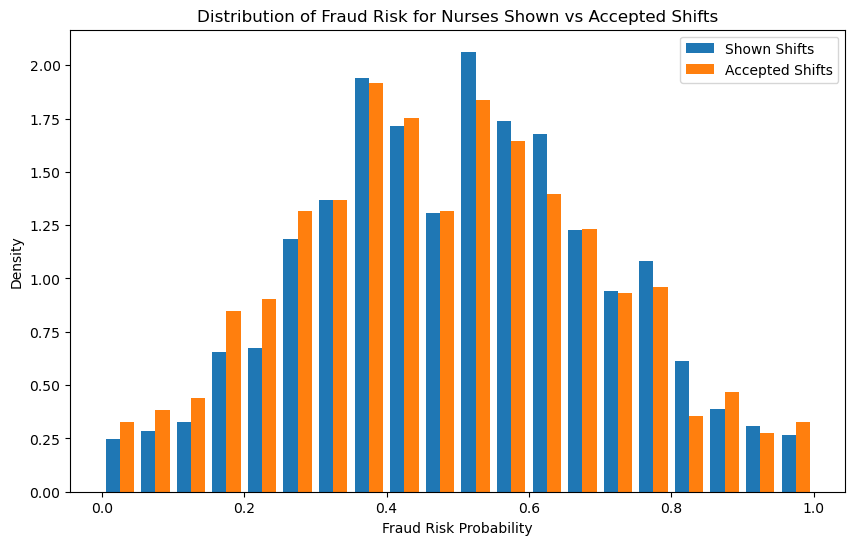


Correlation between fraud risk and number of shifts shown: -0.6010
Correlation between fraud risk and number of shifts accepted: -0.4748
Correlation between pay requirements and number of shifts accepted: -0.2429


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict

# Define sets and parameters
nurses = 1000
shifts = 270  # 90 days * 3 shifts per day
departments = 10
certifications = 8
vaccines = 5
experience_levels = 5

# Fraud detection parameters
fraud_risk_threshold = 0.3
fraud_detection_weight = 0.2

# Assignment parameters
max_shifts_per_nurse = 30
min_shifts_per_nurse = 3
nurses_per_shift = 5
max_shifts_to_show = 9

# Compensation parameters
base_pay_rate = 25
max_pay_rate = 50
shift_duration = 8

def load_nurse_data(file_path='nurses.csv'):
    df = pd.read_csv(file_path)
    D = df[[f'Dept_{i+1}' for i in range(departments)]].values
    C = df[[f'Cert_{i+1}' for i in range(certifications)]].values
    V = df[[f'Vaccine_{i+1}' for i in range(vaccines)]].values
    Y = df[[f'Exp_Dept_{i+1}' for i in range(departments)]].values
    pay_requirements = np.random.uniform(base_pay_rate, max_pay_rate, nurses)
    return D, C, V, Y, pay_requirements

def load_shift_data(file_path='shifts.csv'):
    df = pd.read_csv(file_path)
    N = df[[f'Req_Dept_{i+1}' for i in range(departments)]].values
    B = df[[f'Req_Cert_{i+1}' for i in range(certifications)]].values
    M = df[[f'Req_Vaccine_{i+1}' for i in range(vaccines)]].values
    F = df[[f'Req_Exp_Dept_{i+1}' for i in range(departments)]].values
    compensations = np.random.uniform(base_pay_rate, max_pay_rate, shifts)
    return N, B, M, F, compensations

def load_availability_data(file_path='availability.csv'):
    df = pd.read_csv(file_path)
    availability = df.pivot(index='NurseID', columns='ShiftID', values='IsAvailable').fillna(0).values
    return availability

def load_fraud_risk_data(file_path='fraud_risk.csv'):
    df = pd.read_csv(file_path)
    return df[['PastIncidents', 'LatePunchIns', 'UnexplainedAbsences']].values

def calculate_fraud_probabilities(fraud_risk_data):
    fraud_prob = np.mean(fraud_risk_data / np.max(fraud_risk_data, axis=0), axis=1)
    return fraud_prob

def generate_shift_acceptance_probabilities(nurses):
    return np.random.uniform(0.3, 0.9, nurses)

def calculate_nurse_suitability(nurse_idx, shift_idx, D, C, V, Y, N, B, M, F, availability, fraud_prob, nurse_shown_count, pay_requirements, compensations):
    if availability[nurse_idx, shift_idx] == 0:
        return -np.inf

    dept_match = np.mean(D[nurse_idx] >= N[shift_idx])
    cert_match = np.mean(C[nurse_idx] >= B[shift_idx])
    vacc_match = np.mean(V[nurse_idx] >= M[shift_idx])
    exp_match = np.mean(Y[nurse_idx] >= F[shift_idx])
    
    qualification_score = (dept_match + cert_match + vacc_match + exp_match) / 4
    
    fraud_risk_score = 1 - (fraud_prob[nurse_idx] / fraud_risk_threshold)
    fraud_risk_score = max(0, min(1, fraud_risk_score))
    
    workload_score = 1 - (nurse_shown_count[nurse_idx] / max_shifts_to_show)
    
    compensation_score = min(1, compensations[shift_idx] / pay_requirements[nurse_idx])
    
    suitability = (qualification_score * 0.25 + 
                   fraud_risk_score * 0.3 + 
                   workload_score * 0.2 +
                   compensation_score * 0.25)
    
    return suitability

def fair_shift_distribution(D, C, V, Y, N, B, M, F, availability, fraud_prob, acceptance_probabilities, pay_requirements, compensations):
    shown_shifts = np.zeros((nurses, shifts), dtype=int)
    accepted_shifts = np.zeros((nurses, shifts), dtype=int)
    nurse_shown_count = np.zeros(nurses, dtype=int)
    nurse_accepted_count = np.zeros(nurses, dtype=int)
    shift_accepted_count = np.zeros(shifts, dtype=int)

    sorted_nurses = sorted(range(nurses), key=lambda x: fraud_prob[x])

    for shift in tqdm(range(shifts), desc="Distributing Shifts"):
        shift_day = shift // 3  # Assuming 3 shifts per day
        nurses_needed = nurses_per_shift
        available_nurses = [n for n in sorted_nurses if availability[n, shift] == 1 and 
                            nurse_shown_count[n] < max_shifts_to_show and
                            np.sum(accepted_shifts[n, shift_day*3:(shift_day+1)*3]) == 0]
        
        while nurses_needed > 0 and available_nurses:
            suitabilities = [calculate_nurse_suitability(n, shift, D, C, V, Y, N, B, M, F, availability, fraud_prob, nurse_shown_count, pay_requirements, compensations) 
                             for n in available_nurses]
            
            best_nurse = max(zip(available_nurses, suitabilities), key=lambda x: x[1])[0]
            
            shown_shifts[best_nurse, shift] = 1
            nurse_shown_count[best_nurse] += 1
            
            adjusted_prob = acceptance_probabilities[best_nurse] * min(1, compensations[shift] / pay_requirements[best_nurse])
            
            if np.random.random() < adjusted_prob:
                accepted_shifts[best_nurse, shift] = 1
                nurse_accepted_count[best_nurse] += 1
                shift_accepted_count[shift] += 1
                nurses_needed -= 1
                
                # Remove this nurse from available nurses for this day
                available_nurses = [n for n in available_nurses if n != best_nurse and 
                                    np.sum(accepted_shifts[n, shift_day*3:(shift_day+1)*3]) == 0]
            else:
                # If nurse declines, remove them from available nurses for this shift
                available_nurses.remove(best_nurse)
        
        if nurses_needed > 0:
            print(f"Warning: Not enough nurses for shift {shift}. {nurses_needed} positions unfilled.")

    return shown_shifts, accepted_shifts, nurse_shown_count, nurse_accepted_count, shift_accepted_count

# Load data
print("Loading data...")
D, C, V, Y, pay_requirements = load_nurse_data()
N, B, M, F, compensations = load_shift_data()
availability = load_availability_data()
fraud_risk_data = load_fraud_risk_data()
fraud_prob = calculate_fraud_probabilities(fraud_risk_data)

# Generate shift acceptance probabilities
acceptance_probabilities = generate_shift_acceptance_probabilities(nurses)

# Run the fair shift distribution
print("Running fair shift distribution...")
shown_shifts, accepted_shifts, nurse_shown_count, nurse_accepted_count, shift_accepted_count = fair_shift_distribution(D, C, V, Y, N, B, M, F, availability, fraud_prob, acceptance_probabilities, pay_requirements, compensations)

# Calculate metrics
total_shown = np.sum(shown_shifts)
total_accepted = np.sum(accepted_shifts)
fraud_impact_shown = np.sum(shown_shifts * fraud_prob[:, np.newaxis])
fraud_impact_accepted = np.sum(accepted_shifts * fraud_prob[:, np.newaxis])
objective_value_shown = total_shown - fraud_detection_weight * fraud_impact_shown
objective_value_accepted = total_accepted - fraud_detection_weight * fraud_impact_accepted

print(f"Objective value (shown): {objective_value_shown}")
print(f"Objective value (accepted): {objective_value_accepted}")
print(f"Total shifts shown: {total_shown}")
print(f"Total shifts accepted: {total_accepted}")

# Calculate total compensation
total_compensation = np.sum(accepted_shifts * compensations[np.newaxis, :]) * shift_duration
print(f"Total compensation: ${total_compensation:.2f}")

# Visualizations and analysis (same as before)
# ... [Include all the visualization and analysis code from the previous version]

# New analysis: Match rate
match_rate = total_accepted / total_shown
print(f"\nMatch rate: {match_rate:.2%}")

# New analysis: Distribution of accepted shifts per nurse
plt.figure(figsize=(10, 6))
plt.hist(nurse_accepted_count, bins=range(max(nurse_accepted_count)+2), align='left', rwidth=0.8)
plt.xlabel('Number of Accepted Shifts')
plt.ylabel('Number of Nurses')
plt.title('Distribution of Accepted Shifts per Nurse')
plt.show()

# New analysis: Compensation vs Acceptance
plt.figure(figsize=(10, 6))
plt.scatter(compensations, shift_accepted_count)
plt.xlabel('Shift Compensation')
plt.ylabel('Number of Acceptances')
plt.title('Shift Compensation vs Number of Acceptances')
plt.show()

# Correlation between compensation and acceptance
correlation_comp_acceptance = np.corrcoef(compensations, shift_accepted_count)[0, 1]
print(f"\nCorrelation between compensation and shift acceptance: {correlation_comp_acceptance:.4f}")

# Visualizations
plt.figure(figsize=(12, 6))
plt.imshow(shown_shifts, cmap='Blues', aspect='auto')
plt.colorbar(label='Shown')
plt.xlabel('Shifts')
plt.ylabel('Nurses')
plt.title('Nurse-Shift Shown Distribution')
plt.show()

plt.figure(figsize=(12, 6))
plt.imshow(accepted_shifts, cmap='Greens', aspect='auto')
plt.colorbar(label='Accepted')
plt.xlabel('Shifts')
plt.ylabel('Nurses')
plt.title('Nurse-Shift Accepted Distribution')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist([nurse_shown_count, nurse_accepted_count], label=['Shown', 'Accepted'], bins=range(max_shifts_to_show + 2), align='left', rwidth=0.8)
plt.xlabel('Number of Shifts')
plt.ylabel('Number of Nurses')
plt.title('Distribution of Shifts Shown and Accepted')
plt.legend()
plt.show()

# Additional analysis
print(f"\nAverage shifts shown per nurse: {np.mean(nurse_shown_count):.2f}")
print(f"Average shifts accepted per nurse: {np.mean(nurse_accepted_count):.2f}")
print(f"Maximum shifts shown to a nurse: {np.max(nurse_shown_count)}")
print(f"Maximum shifts accepted by a nurse: {np.max(nurse_accepted_count)}")
print(f"Nurses with no shifts shown: {np.sum(nurse_shown_count == 0)}")
print(f"Nurses with no shifts accepted: {np.sum(nurse_accepted_count == 0)}")
print(f"Nurses shown maximum shifts: {np.sum(nurse_shown_count == max_shifts_to_show)}")

# Fraud risk analysis
high_risk_shown = np.sum(shown_shifts[fraud_prob > fraud_risk_threshold])
high_risk_accepted = np.sum(accepted_shifts[fraud_prob > fraud_risk_threshold])
print(f"\nShifts shown to high-risk nurses: {high_risk_shown}")
print(f"Shifts accepted by high-risk nurses: {high_risk_accepted}")
print(f"Percentage of high-risk shown shifts: {high_risk_shown / total_shown * 100:.2f}%")
print(f"Percentage of high-risk accepted shifts: {high_risk_accepted / total_accepted * 100:.2f}%")

# Low-risk nurse analysis
low_risk_nurses = np.sum(fraud_prob <= fraud_risk_threshold)
low_risk_shown = np.sum(shown_shifts[fraud_prob <= fraud_risk_threshold])
low_risk_accepted = np.sum(accepted_shifts[fraud_prob <= fraud_risk_threshold])
print(f"Number of low-risk nurses: {low_risk_nurses}")
print(f"Shifts shown to low-risk nurses: {low_risk_shown}")
print(f"Shifts accepted by low-risk nurses: {low_risk_accepted}")
print(f"Percentage of shifts shown to low-risk nurses: {low_risk_shown / total_shown * 100:.2f}%")
print(f"Percentage of shifts accepted by low-risk nurses: {low_risk_accepted / total_accepted * 100:.2f}%")

# Shift coverage analysis
fully_shown_shifts = np.sum(np.sum(shown_shifts, axis=0) >= nurses_per_shift)
fully_accepted_shifts = np.sum(shift_accepted_count >= nurses_per_shift)
partially_shown_shifts = np.sum((np.sum(shown_shifts, axis=0) > 0) & (np.sum(shown_shifts, axis=0) < nurses_per_shift))
partially_accepted_shifts = np.sum((shift_accepted_count > 0) & (shift_accepted_count < nurses_per_shift))
not_shown_shifts = np.sum(np.sum(shown_shifts, axis=0) == 0)
not_accepted_shifts = np.sum(shift_accepted_count == 0)

print(f"\nFully shown shifts: {fully_shown_shifts}")
print(f"Fully accepted shifts: {fully_accepted_shifts}")
print(f"Partially shown shifts: {partially_shown_shifts}")
print(f"Partially accepted shifts: {partially_accepted_shifts}")
print(f"Not shown shifts: {not_shown_shifts}")
print(f"Not accepted shifts: {not_accepted_shifts}")
print(f"Percentage of fully shown shifts: {fully_shown_shifts / shifts * 100:.2f}%")
print(f"Percentage of fully accepted shifts: {fully_accepted_shifts / shifts * 100:.2f}%")

# Position analysis
total_positions = shifts * nurses_per_shift
shown_positions = np.sum(np.sum(shown_shifts, axis=0))
accepted_positions = np.sum(shift_accepted_count)
print(f"\nTotal positions: {total_positions}")
print(f"Shown positions: {shown_positions}")
print(f"Accepted positions: {accepted_positions}")
print(f"Percentage of shown positions: {shown_positions / total_positions * 100:.2f}%")
print(f"Percentage of accepted positions: {accepted_positions / total_positions * 100:.2f}%")

# Compensation analysis
average_compensation_per_shift = np.mean(compensations)
average_pay_requirement = np.mean(pay_requirements)
print(f"\nAverage compensation per shift: ${average_compensation_per_shift:.2f}")
print(f"Average pay requirement of nurses: ${average_pay_requirement:.2f}")

# Fraud risk distribution visualization
plt.figure(figsize=(10, 6))
plt.hist([fraud_prob[nurse_shown_count > 0], fraud_prob[nurse_accepted_count > 0]], 
         label=['Shown Shifts', 'Accepted Shifts'], bins=20, density=True)
plt.xlabel('Fraud Risk Probability')
plt.ylabel('Density')
plt.title('Distribution of Fraud Risk for Nurses Shown vs Accepted Shifts')
plt.legend()
plt.show()

# Correlation analysis
correlation_shown = np.corrcoef(fraud_prob, nurse_shown_count)[0, 1]
correlation_accepted = np.corrcoef(fraud_prob, nurse_accepted_count)[0, 1]
correlation_pay_req_accepted = np.corrcoef(pay_requirements, nurse_accepted_count)[0, 1]
print(f"\nCorrelation between fraud risk and number of shifts shown: {correlation_shown:.4f}")
print(f"Correlation between fraud risk and number of shifts accepted: {correlation_accepted:.4f}")
print(f"Correlation between pay requirements and number of shifts accepted: {correlation_pay_req_accepted:.4f}")